# WEB SCRAPING

In [1]:
%cd ..
# %cd media/capstone-project

D:\OneDrive\w210\capstone-project


In [2]:
import requests
from bs4 import BeautifulSoup
from collections import OrderedDict
import pprint
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import time

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## Scaping Drug Information From Drugbank.com

In [11]:
# # Extract all unique drug_id from DDIs
# ddis = pd.read_csv('data/ddis_from_api_negative_control.csv', sep='\t')
# drugbank_ids = sorted(set(ddis['d1'].unique()) | set(ddis['d2'].unique()))
# ddis_smiles = ddis.dropna(subset=['smiles1', 'smiles2'], how='any')
# drugbank_ids_smiles = sorted(set(ddis_smiles['d1'].unique()) | set(ddis_smiles['d2'].unique()))
# print('Number of interactions with SMILES:', ddis_smiles.shape)
# print('Number of distinct drugs:', len(drugbank_ids))
# print('Number of distinct drugs with SMILES:', len(drugbank_ids_smiles))
# print('Example of drug ID:', drugbank_ids_smiles[:10])

Number of interactions with SMILES: (1847556, 9)
Number of distinct drugs: 3032
Number of distinct drugs with SMILES: 1704
Example of drug ID: ['DB00006', 'DB00014', 'DB00027', 'DB00035', 'DB00080', 'DB00091', 'DB00104', 'DB00115', 'DB00120', 'DB00122']


In [3]:
# All unique_id from web_scraping with SMILES
ddis_smiles = pd.read_csv('data/scraping_drug_smiles.csv')
ddis_smiles = ddis_smiles[ddis_smiles["SMILES"] != "Not Available"]
drugbank_ids = sorted(set(ddis_smiles['drug_id'].unique()))
print('Number of distinct drugs with SMILES:', len(drugbank_ids))
print('Example of drug ID:', drugbank_ids[:10])

Number of distinct drugs with SMILES: 2567
Example of drug ID: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']


In [13]:
def get_drugbank_information(drugbank_id, verbose=False):
    """Parse drug detailed information from drugbank.com website"""
    # Initialize
    global processed_id

    # URL to scrape
    url = f"https://go.drugbank.com/drugs/{drugbank_id}"

    # Send GET request
    response = requests.get(url)

    if response.status_code == 200:
        # parse the content as HTML
        try:
            soup = BeautifulSoup(response.content, "html.parser")
            # print(soup.prettify())

        except:
            print('Could not find drug information for', drugbank_id)
            soup = None
            processed_id.append(drugbank_id)

        if soup:
            # Extract each section (dl_element) from card_content
            content_container = soup.find('div', class_='content-container')
            drug_content = content_container.find('div', class_='drug-content')
            drug_card = drug_content.find('div', class_='drug-card')
            card_content = drug_card.find('div', class_='card-content')
            dl_elements = card_content.find_all('dl')

            # Initialize drug_info dict, ensure None value is return if not found
            keys = ['drug_id', 'generic_name', 'SMILES', 'drug_summary', 'brand_names', 'type',
                    'groups', 'weight', 'chemical_formula', 'synonyms', 'indication',
                    'conditions', 'pharmacodynamics', 'mechanism_of_action',
                    'target', 'protein_binding','metabolism', 'half_life','clearance',
                    'metabolism_pathway', 'action_pathway', 'UNII', 'CAS']
            drug_info = OrderedDict.fromkeys(keys)

            # Extracting texts
            for dl in dl_elements:
                # all term elements under each section
                dts = dl.find_all('dt')  # all terms, distinguish by id
                dds = dl.find_all('dd')  # all definition/texts for each term

                # Looping through each term, definition element
                for dt, dd in zip(dts, dds):
                    try:
                        dt_id = dt["id"]
                        ## 1. IDENTIFICATION
                        # Drug summary
                        if dt_id == 'summary':
                            drug_info['drug_summary'] = dd.text.strip().replace('\n', ' ')

                        # Brand names
                        if dt_id == 'brand-names':
                            drug_info['brand_names'] = dd.text.strip().replace('\n', ', ')

                        # Generic name
                        if dt_id == 'generic-name':
                            drug_info['generic_name'] = dd.text.strip()

                        # Drugbank id
                        if dt_id == 'drugbank-accession-number':
                            drug_info['drug_id'] = dd.text.strip()

                        # Drug Type
                        if dt_id == 'type':
                            drug_info['type'] = dd.text.strip()

                        # Group
                        if dt_id == 'groups':
                            drug_info['groups'] = dd.text.strip().replace('\n', ', ')

                        # Weight
                        if dt_id == 'weight':
                            drug_info['weight'] = dd.text.strip()

                        # Chemical Formula
                        if dt_id == 'chemical-formula':
                            drug_info['chemical_formula'] = dd.text.strip()

                        # Synonyms
                        if dt_id == 'synonyms':
                            synonyms = []
                            li_elements = dd.find_all('li')
                            for li in li_elements:
                                synonym = li.text.strip()
                                synonyms.append(synonym)
                            drug_info['synonyms'] = ' | '.join(synonyms)

                        ## 2. PHARMACOLOGY
                        # Indication
                        if dt_id == 'indication':
                            drug_info['indication'] = dd.text.strip().replace('\n', '').replace('â€¢', '.')

                        # Associated Conditions
                        if dt_id == 'associated-conditions':
                            conditions = []
                            li_elements = dd.find_all('li')
                            for li in li_elements:
                                condition = li.text.strip()
                                conditions.append(condition)
                            drug_info['conditions'] = ' | '.join(conditions)

                        # Contraindications
                        # if dt_id == 'contraindications-blackbox-warnings':
                        #     drug_info['contraindications'] = dd.text \
                        #         .replace('Avoid life-threatening adverse drug events', '') \
                        #         .replace(
                        #         'Improve clinical decision support with information on contraindications & blackbox warnings, population restrictions, harmful risks, & more.',
                        #         '') \
                        #         .replace('Learn more', '') \
                        #         .replace('Avoid life-threatening adverse drug events', '') \
                        #         .replace('& improve clinical decision support.', '').strip()

                        # Pharmacodynamics
                        if dt_id == 'pharmacodynamics':
                            drug_info['pharmacodynamics'] = dd.text.strip().replace('\n', ' | ')

                        # Mechanism of action & target
                        if dt_id == 'mechanism-of-action':
                            mechanisms = []
                            p_mechanism = dd.find_all('p')  # All paragraphs
                            for p in p_mechanism:
                                mechanism = p.text.strip()
                                mechanisms.append(mechanism)
                            drug_info['mechanism_of_action'] = ' | '.join(mechanisms).replace('\n', ' | ')

                            # Target
                            drug_targets = []
                            target_table = dd.find('table')
                            target_body = target_table.find('tbody')
                            target_protein = target_body.find_all('a')
                            target_span = dd.find_all('span')
                            target_class = dd.find_all('div')

                            for _span, _protein, _class in zip(target_span, target_protein, target_class):
                                target_info = f'Category: {_span.text}, Protein: {_protein.text}, Actions: {_class.text}'
                                drug_targets.append(target_info)

                            drug_info['target'] = ' | '.join(drug_targets)

                        # Protein Binding
                        if dt_id == 'protein-binding':
                            drug_info['protein_binding'] = dd.text.strip().replace('\n', ' | ')

                        # Metabolism
                        if dt_id == 'metabolism':
                            paragraph = dd.find('p').text.strip()
                            metabolite = dd.find('li').text.strip().replace('\n\n\n', ' > ').replace('\n', ' | ')
                            if metabolite :
                                paragraph = f'{paragraph} | Metabolite: {metabolite}'
                            drug_info['metabolism'] = paragraph

                        # Half-life
                        if dt_id == 'half-life':
                            drug_info['half_life'] = dd.text.strip().replace('\n', ' | ')

                        # Clearance
                        if dt_id == 'clearance':
                            drug_info['clearance'] = dd.text.strip().replace('\n', ' | ')

                        # Pathways
                        if dt_id == 'pathways':
                            path_table = dd.find('table')
                            if path_table:
                                path_body = path_table.find('tbody')
                                path_tr = path_body.find_all('tr')
                                for each_tr in path_tr:
                                    path_td = each_tr.find_all('td')
                                    url_link = path_td[0].find("a")["href"]
                                    url_category = path_td[1].text
                                    # pathway = get_pathway(url_link)
                                    if url_category == 'Drug metabolism':
                                        drug_info['metabolism_pathway'] = url_link
                                    if url_category == 'Drug action':
                                        drug_info['action_pathway'] = url_link

                        # UNII
                        if dt_id == 'unii':
                            drug_info['UNII'] = dd.text.strip()

                        # CAS
                        if dt_id == 'cas-number':
                            drug_info['CAS'] = dd.text.strip()

                        # SMILES
                        if dt_id == 'smiles':
                            drug_info['SMILES'] = dd.text.strip()

                    except:
                        continue

            if verbose:
                pprint.pprint(drug_info)
            processed_id.append(drugbank_id)
            return drug_info

In [14]:
# Test scraping function with a drug_id
# drugbank_id = 'DB00316'
drugbank_id = 'DB00118'
processed_id = []
drug_info = get_drugbank_information(drugbank_id, verbose=True)

OrderedDict([('drug_id', 'DB00118'),
             ('generic_name', 'Ademetionine'),
             ('SMILES',
              'C[S+](CC[C@H](N)C([O-])=O)C[C@H]1O[C@H]([C@H](O)[C@@H]1O)N1C=NC2=C1N=CN=C2N'),
             ('drug_summary', None),
             ('brand_names', None),
             ('type', 'Small Molecule'),
             ('groups', 'Approved, Investigational, Nutraceutical'),
             ('weight', 'Average: 398.44 Monoisotopic: 398.137239006'),
             ('chemical_formula', 'C15H22N6O5S'),
             ('synonyms',
              'Ademetionine | AdoMet | L-S-Adenosylmethionine | '
              'S-Adenosylmethionine | SAM | SAM-e | SAMe'),
             ('indication',
              'S-Adenosylmethionine (SAMe) is used as a drug in Europe for the '
              'treatment of depression, liver disorders, fibromyalgia, and '
              'osteoarthritis. It has also been introduced into the United '
              'States market as a dietary supplement for the support of bone '

In [15]:
# Scraping all drugs from web
processed_id = []
drug_infos = []

i = 0
for drugbank_id in drugbank_ids:
    if i % 50 == 0:
        print(f'Scraping {i} to {i+50} Drug Ids...')
    if drugbank_id not in processed_id:
        drug_info = get_drugbank_information(drugbank_id)
        if drug_info:
            drug_infos.append(drug_info)
        with open("data/drug_info_scraping.txt", "a", encoding='utf8') as f: # Open the file in append mode
            f.write(str(drug_info))
            f.write("\n")
    i += 1 

Scraping 0 to 50 Drug Ids...
Scraping 50 to 100 Drug Ids...
Scraping 100 to 150 Drug Ids...
Scraping 150 to 200 Drug Ids...
Scraping 200 to 250 Drug Ids...
Scraping 250 to 300 Drug Ids...
Scraping 300 to 350 Drug Ids...
Scraping 350 to 400 Drug Ids...
Scraping 400 to 450 Drug Ids...
Scraping 450 to 500 Drug Ids...
Scraping 500 to 550 Drug Ids...
Scraping 550 to 600 Drug Ids...
Scraping 600 to 650 Drug Ids...
Scraping 650 to 700 Drug Ids...
Scraping 700 to 750 Drug Ids...
Scraping 750 to 800 Drug Ids...
Scraping 800 to 850 Drug Ids...
Scraping 850 to 900 Drug Ids...
Scraping 900 to 950 Drug Ids...
Scraping 950 to 1000 Drug Ids...
Scraping 1000 to 1050 Drug Ids...
Scraping 1050 to 1100 Drug Ids...
Scraping 1100 to 1150 Drug Ids...
Scraping 1150 to 1200 Drug Ids...
Scraping 1200 to 1250 Drug Ids...
Scraping 1250 to 1300 Drug Ids...
Scraping 1300 to 1350 Drug Ids...
Scraping 1350 to 1400 Drug Ids...
Scraping 1400 to 1450 Drug Ids...
Scraping 1450 to 1500 Drug Ids...
Scraping 1500 to 1550 D

### EDA

In [133]:
drug_info_df = pd.DataFrame(drug_infos)

print('Drug Information Dimension:', drug_info_df.shape)
print('Number of distinct drugs:', len(drug_info_df['drug_id'].unique()))
print('Number of drugs having SMILES:', len(drug_info_df['SMILES'].unique()))

approved_drugs = drug_info_df[drug_info_df['groups'].str.contains('Approved')]
not_approved_drugs = drug_info_df[~drug_info_df['groups'].str.contains('Approved')]
print('Number of drugs in Approved group:', approved_drugs.shape[0])
print('Number of drugs NOT in Approved group:', not_approved_drugs.shape[0])

# Create a new column for Approved Drugs
drug_info_df["approved_drug"] = np.where(drug_info_df['groups'].str.contains('Approved'), 1, 0)

# Count the number of drugs have pathways:
metabolism_pathways = drug_info_df[~drug_info_df["metabolism_pathway"].isnull()][["metabolism_pathway"]]
action_pathways = drug_info_df[~drug_info_df["action_pathway"].isnull()][["action_pathway"]]
print("Number of drugs have metabolism pathways:", metabolism_pathways.shape)
print("Number of drugs have action pathways:", action_pathways.shape)
print('Number of missing values:\n', drug_info_df.isnull().sum())

# print(drug_info_df['groups'].value_counts())
drug_info_df.head(2)

Drug Information Dimension: (2567, 23)
Number of distinct drugs: 2567
Number of drugs having SMILES: 2567
Number of drugs in Approved group: 2040
Number of drugs NOT in Approved group: 527
Number of drugs have metabolism pathways: (71, 1)
Number of drugs have action pathways: (381, 1)
Number of missing values:
 drug_id                   0
generic_name              0
SMILES                    0
drug_summary            654
brand_names            1180
type                      0
groups                    0
weight                    0
chemical_formula          0
synonyms                  0
indication                0
conditions              751
pharmacodynamics          0
mechanism_of_action       0
target                  591
protein_binding           0
metabolism             1730
half_life                 0
clearance                 0
metabolism_pathway     2496
action_pathway         2186
UNII                      0
CAS                       0
approved_drug             0
dtype: int64


,drug_id,generic_name,SMILES,drug_summary,brand_names,type,groups,weight,chemical_formula,synonyms,indication,conditions,pharmacodynamics,mechanism_of_action,target,protein_binding,metabolism,half_life,clearance,metabolism_pathway,action_pathway,UNII,CAS,approved_drug
0,DB00006,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,Bivalirudin is a direct thrombin inhibitor used to treat heparin-induced thrombocytopenia and to...,Angiomax,Small Molecule,"Approved, Investigational",Average: 2180.2853 Monoisotopic: 2178.985813062,C98H138N24O33,Bivalirudin | Bivalirudina | Bivalirudinum,For treatment of heparin-induced thrombocytopenia and for the prevention of thrombosis. Bivaliru...,Thrombosis,Bivalirudin mediates an inhibitory action on thrombin by directly and specifically binding to bo...,Inhibits the action of thrombin by binding both to its catalytic site and to its anion-binding e...,"Category: A, Protein: Prothrombin, Actions: inhibitor","Other than thrombin and red blood cells, bivalirudin does not bind to plasma proteins.",None,Normal renal function: 25 min (in normal conditions) | Creatinine clearance 10-29mL/min: 57min |...,3.4 mL/min/kg [Normal renal function] | 3.4 mL/min/kg [mild renal function] | 2.7 mL/min/kg [mod...,None,http://smpdb.ca/view/SMP0000277?highlight[compounds][]=DB00006&highlight[proteins][]=DB00006,TN9BEX005G,128270-60-0,1
1,DB00007,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](CC1...,Leuprolide is a peptide-based GnRH receptor superagonist used for the palliative treatment of pr...,"Camcevi, Eligard, Fensolvi, Lupaneta Pack 1-month, Lupron, Lupron Depot-ped, Viadur, Zeulide Depot",Small Molecule,"Approved, Investigational",Average: 1209.3983 Monoisotopic: 1208.645462232,C59H84N16O12,Leuprorelin | Leuprorelina | Leuproreline | Leuprorelinum,"Leuprolide is indicated for the treatment of advanced prostate cancer 6,12 and as palliative tre...",Advanced Prostate Cancer | Anemia | Central Precocious Puberty (CPP) | Endometriosis,Leuprolide is a gonadotropin-releasing hormone (GnRH) analogue that functions as a GnRH receptor...,Gonadotropin-releasing hormone (GnRH) is a naturally occurring decapeptide that modulates the hy...,"Category: A, Protein: Gonadotropin-releasing hormone receptor, Actions: agonist","Leuprolide displays in vitro binding to human plasma proteins between 43% and 49%.5,6,7,8,9,10,12",None,"Leuprolide has a terminal elimination half-life of approximately three hours.5,6,7,8,9,10,12",Leuprolide administered as a 1 mg intravenous bolus in healthy males has a mean systemic clearan...,None,None,EFY6W0M8TG,53714-56-0,1


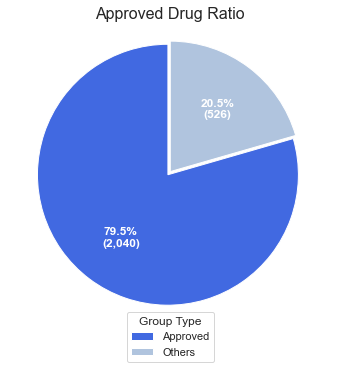

In [134]:
data = [approved_drugs.shape[0], not_approved_drugs.shape[0]]
labels = ['Approved', 'Others']


def func(pct, allvals):                    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Group Type",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Approved Drug Ratio", fontsize=16, y=0.95)
plt.show()

In [135]:
drug_info_df["mechanism_of_action"] = np.where(drug_info_df["mechanism_of_action"].isin(["", "N/A", "not available"]),
                                               'Not Available', drug_info_df["mechanism_of_action"])
drug_info_df["target"] = np.where(drug_info_df["target"].isin(["", "N/A", "not available"]),
                                               'Not Available', drug_info_df["target"])
drug_info_df["clearance"] = np.where(drug_info_df["clearance"].isin(["", "N/A", "not available"]),
                                               'clearance', drug_info_df["target"])

# Replace missing values with "Not Available"
drug_info_df = drug_info_df.fillna("Not Available")

In [141]:
# Save data to csv
drug_info_df.to_csv('data/scraping_drug_info.csv', index=False, sep='\t')
drug_info_df.to_csv("data/scraping_drug_info.txt", index=False, sep='\t')

# Read data
# drug_info_df = pd.read_csv('data/scraping_drug_info.csv', delimiter='\t')
drug_info_df.head(2)

,drug_id,generic_name,SMILES,drug_summary,brand_names,type,groups,weight,chemical_formula,synonyms,indication,conditions,pharmacodynamics,mechanism_of_action,target,protein_binding,metabolism,half_life,clearance,metabolism_pathway,action_pathway,UNII,CAS,approved_drug
0,DB00006,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,Bivalirudin is a direct thrombin inhibitor used to treat heparin-induced thrombocytopenia and to...,Angiomax,Small Molecule,"Approved, Investigational",Average: 2180.2853 Monoisotopic: 2178.985813062,C98H138N24O33,Bivalirudin | Bivalirudina | Bivalirudinum,For treatment of heparin-induced thrombocytopenia and for the prevention of thrombosis. Bivaliru...,Thrombosis,Bivalirudin mediates an inhibitory action on thrombin by directly and specifically binding to bo...,Inhibits the action of thrombin by binding both to its catalytic site and to its anion-binding e...,"Category: A, Protein: Prothrombin, Actions: inhibitor","Other than thrombin and red blood cells, bivalirudin does not bind to plasma proteins.",Not Available,Normal renal function: 25 min (in normal conditions) | Creatinine clearance 10-29mL/min: 57min |...,"Category: A, Protein: Prothrombin, Actions: inhibitor",Not Available,http://smpdb.ca/view/SMP0000277?highlight[compounds][]=DB00006&highlight[proteins][]=DB00006,TN9BEX005G,128270-60-0,1
1,DB00007,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](CC1...,Leuprolide is a peptide-based GnRH receptor superagonist used for the palliative treatment of pr...,"Camcevi, Eligard, Fensolvi, Lupaneta Pack 1-month, Lupron, Lupron Depot-ped, Viadur, Zeulide Depot",Small Molecule,"Approved, Investigational",Average: 1209.3983 Monoisotopic: 1208.645462232,C59H84N16O12,Leuprorelin | Leuprorelina | Leuproreline | Leuprorelinum,"Leuprolide is indicated for the treatment of advanced prostate cancer 6,12 and as palliative tre...",Advanced Prostate Cancer | Anemia | Central Precocious Puberty (CPP) | Endometriosis,Leuprolide is a gonadotropin-releasing hormone (GnRH) analogue that functions as a GnRH receptor...,Gonadotropin-releasing hormone (GnRH) is a naturally occurring decapeptide that modulates the hy...,"Category: A, Protein: Gonadotropin-releasing hormone receptor, Actions: agonist","Leuprolide displays in vitro binding to human plasma proteins between 43% and 49%.5,6,7,8,9,10,12",Not Available,"Leuprolide has a terminal elimination half-life of approximately three hours.5,6,7,8,9,10,12","Category: A, Protein: Gonadotropin-releasing hormone receptor, Actions: agonist",Not Available,Not Available,EFY6W0M8TG,53714-56-0,1


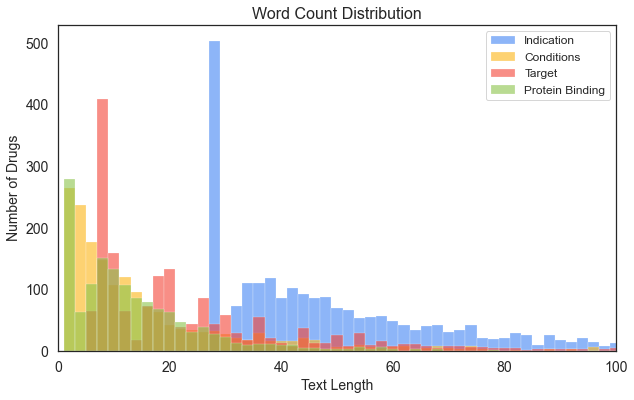

In [136]:
# EDA 
# Calculate word counts
def tokenize(x):
    if x:
        return len(x.split(' '))
    else:
        return 0

df = drug_info_df.copy()
df['word_count_indication'] = df['indication'].apply(tokenize)
df['word_count_conditions'] = df['conditions'].apply(tokenize)
df['word_count_target'] = df['target'].apply(tokenize)
df['word_count_protein'] = df['protein_binding'].apply(tokenize)

### Plot the word-count distribution for the toxic texts and the non toxic texts.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')

# calculate the bin size based on the range of the data
bins = range(min(df['word_count_indication'].min(), df['word_count_conditions'].min()), 
             max(df['word_count_indication'].max(), df['word_count_conditions'].max()) + 2, 2)

# plot the histograms with the same bin size
sns.histplot(data=df[df["indication"] != "Not Available"], x='word_count_indication', label='Indication', bins=bins, color='#4285F4', alpha=0.6)
sns.histplot(data=df[df["conditions"] != "Not Available"], x='word_count_conditions', label='Conditions', bins=bins, color='#FDB515', alpha=0.6)
sns.histplot(data=df[df["target"] != "Not Available"], x='word_count_target', label='Target', bins=bins, color='#F44336', alpha=0.6)
sns.histplot(data=df[df["protein_binding"] != "Not Available"], x='word_count_protein', label='Protein Binding', bins=bins, color='#8BC34A', alpha=0.6)

# set the axis labels and title
ax.set_xlabel('Text Length', fontsize=14)
ax.set_ylabel('Number of Drugs', fontsize=14)
ax.set_title('Word Count Distribution', fontsize=16)
ax.set_xlim(0, 100)

# set the legend and adjust its position
plt.legend(loc='upper right', fontsize=12)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [137]:
# Count number of drugs have "Not Available" data
def count_na_distribution(df, column):
    not_avail = df[df[column].isin(['Not Available', 'not available'])].shape[0]
    available = df.shape[0] - not_avail
    return column, available, not_avail

# Extract the Missing Values/ Not Available for some important drug features
data_distributions = []
features = ["SMILES", "drug_summary", "groups", "mechanism_of_action",
            "target", "protein_binding", "metabolism", "metabolism_pathway",
            "action_pathway", "half_life", "clearance", "indication", 
            "conditions", "pharmacodynamics"]
for column in features:
    data_count = count_na_distribution(drug_info_df, column)
    data_distributions.append(data_count)
    
# Create a dataframe from the list with column names
df_distribution = pd.DataFrame(data_distributions, columns=['Feature', 'Available Data', 'Missing Data'])
df_distribution 

,Feature,Available Data,Missing Data
0,SMILES,2567,0
1,drug_summary,1913,654
2,groups,2567,0
3,mechanism_of_action,2031,536
4,target,1852,715
5,protein_binding,1440,1127
6,metabolism,837,1730
7,metabolism_pathway,71,2496
8,action_pathway,381,2186
9,half_life,1632,935


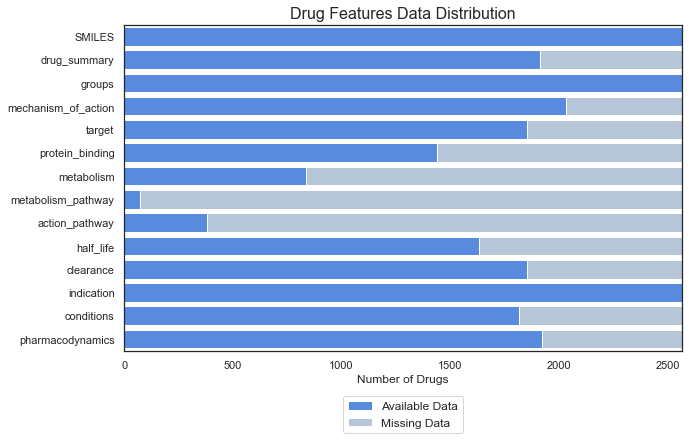

In [138]:
# Create a stacked horizontal bar chart using seaborn barplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')
# sns.set_theme(style="white")
sns.barplot(x="Available Data", y="Feature", data=df_distribution, label="Available Data", color='#4285F4')
sns.barplot(x="Missing Data", y="Feature", data=df_distribution, left=df_distribution["Available Data"], label="Missing Data", color="lightsteelblue")

# Add title and labels
plt.title('Drug Features Data Distribution', fontsize=16)
plt.xlabel('Number of Drugs', fontsize=12)
plt.ylabel(None)
plt.legend(loc="lower center", fontsize=12,
          bbox_to_anchor=(0.25, -0.27, 0.5, 1))

# Add legend
plt.show()

In [139]:
# Count the max & mean word counts for the features
def word_count(df, column):
    available_df = df[~df[column].isin(['Not Available', 'not available'])]
    min_length = available_df[column].str.len().min()
    max_length = available_df[column].str.len().max()
    avg_length = round(available_df[column].str.len().median())
    # available = df.shape[0] - not_avail
    return column, avg_length, min_length, max_length

# Test word_count
# word_count(df, "drug_summary")

wordcount_distributions = []
for column in features:
    _count = word_count(drug_info_df, column)
    wordcount_distributions.append(_count)
    
# Create a dataframe from the list with column names
df_word_count = pd.DataFrame(wordcount_distributions, columns=['Feature', 'Median Length', 'Min Length', 'Max Length'])
df_word_count

,Feature,Median Length,Min Length,Max Length
0,SMILES,51,2,748
1,drug_summary,128,36,313
2,groups,17,7,54
3,mechanism_of_action,599,39,6926
4,target,147,41,24879
5,protein_binding,67,2,1099
6,metabolism,443,45,2296
7,metabolism_pathway,92,92,92
8,action_pathway,92,92,92
9,half_life,72,2,1026


In [140]:
drug_info_df[drug_info_df['SMILES'].str.len() == 2].head(2)

,drug_id,generic_name,SMILES,drug_summary,brand_names,type,groups,weight,chemical_formula,synonyms,indication,conditions,pharmacodynamics,mechanism_of_action,target,protein_binding,metabolism,half_life,clearance,metabolism_pathway,action_pathway,UNII,CAS,approved_drug
1894,DB11091,Hydrogen peroxide,OO,Hydrogen peroxide is a compound used as a disinfectant and sterilizer.,"Eskata, Orajel Mouth Sore Rinse",Small Molecule,"Approved, Vet approved",Average: 34.0147 Monoisotopic: 34.005479308,H2O2,Hydrogen peroxide,Indicated to be used as a disinfectant and sterilizer. Reduce drug development failure ratesBuil...,Ear infection bacterial | Seborrheic Keratosis (SK) | Impacted ear wax | Superficial skin infect...,"Hydrogen peroxide exhibits antimicrobial properties against most forms of microorganisms, includ...",The production of free hydroxyl radicals in the Fenton reaction is thought to be the basis of bi...,Not Available,Not Available,"Hydrogen peroxide is reduced by glutathione peroxidase, which is an endogenous enzyme in human t...",Not Available,Not Available,Not Available,Not Available,BBX060AN9V,7722-84-1,1


In [142]:
drug_info_df[drug_info_df['target'].str.len() == 24879].head(2)

,drug_id,generic_name,SMILES,drug_summary,brand_names,type,groups,weight,chemical_formula,synonyms,indication,conditions,pharmacodynamics,mechanism_of_action,target,protein_binding,metabolism,half_life,clearance,metabolism_pathway,action_pathway,UNII,CAS,approved_drug
2083,DB12010,Fostamatinib,COC1=CC(NC2=NC=C(F)C(NC3=NC4=C(OC(C)(C)C(=O)N4COP(O)(O)=O)C=C3)=N2)=CC(OC)=C1OC,Fostamatinib is a spleen tyrosine kinase inhibitor used to treat chronic immune thrombocytopenia...,Tavalisse,Small Molecule,"Approved, Investigational",Average: 580.4595 Monoisotopic: 580.148291177,C23H26FN6O9P,Fostamatinib,Fostamatinib is indicated for use in the treatment of chronic immune thrombocytopenia (ITP) in p...,Chronic immune thrombocytopenia,"The active metabolite of fostamatinib, R406, inhibits signal transduction by Fcγ receptors invol...","The active metabolite of fostamatinib, R406, is an inhibitor of spleen tyrosine kinase (Syk) 2. ...","Category: A, Protein: Tyrosine-protein kinase SYK, Actions: inhibitor | Category: U, Protein: Ad...",R406 is 98.3% bound to plasma proteins Label.,Fostamatinib is metabolized in the gut by alkaline phosphatase to the active metabolite R406 Lab...,"R406 has a half-life of elimination of approximately 15 h 6,Label.","Category: A, Protein: Tyrosine-protein kinase SYK, Actions: inhibitor | Category: U, Protein: Ad...",Not Available,Not Available,SQ8A3S5101,901119-35-5,1


## Scraping Pathways from SMPDB
### Metabolism Pathways

In [159]:
def get_pathway(url_link, verbose=False):
    """Parse drug pathway data from smpdc.ca website"""
    # Send GET request
    response = requests.get(url_link)

    if response.status_code == 200:
        # parse the content as HTML
        try:
            soup = BeautifulSoup(response.content, "html.parser")
            # print(soup.prettify())

        except:
            print('Could not find drug information for', url_link)
            soup = None

        if soup:
            path_way = soup.find('div', id='des_content')
            if path_way:
                path_way_text = path_way.find_all('div')[-1].text.strip().replace('\n', ' ')
            else:
                path_way_text = "Not Available"
            if verbose:
                print(path_way_text)
            return path_way_text

In [150]:
metabolism_urls = drug_info_df[drug_info_df["metabolism_pathway"] != "Not Available"]["metabolism_pathway"].values
print('Total metabolism pathway found:', len(metabolism_urls))

# test scraping pathway
url_link = metabolism_urls[0]
print(url_link)
get_pathway(url_link)

Total metabolism pathway found: 71
http://smpdb.ca/view/SMP0000597?highlight[compounds][]=DB00178&highlight[proteins][]=DB00178


"Ramipril (trade name: Altace) belongs to the class of drugs known as angiotensin-converting enzyme (ACE) inhibitors and is used primarily to lower high blood pressure (hypertension). This drug can also be used in the treatment of congestive heart failure and type II diabetes. Ramipril is a prodrug which, following oral administration, undergoes biotransformation in vivo into its active form ramiprilat via cleavage of its ester group by the liver. Angiotensin-converting enzyme (ACE) is a component of the body's renin–angiotensin–aldosterone system (RAAS) and cleaves inactive angiotensin I into the active vasoconstrictor angiotensin II. ACE (or kininase II) also degrades the potent vasodilator bradykinin. Consequently, ACE inhibitors decrease angiotensin II concentrations and increase bradykinin concentrations resulting in blood vessel dilation and thereby lowering blood pressure."

In [153]:
metabolism_pathways = []

i = 0
for url_link in metabolism_urls:
    if i % 5 == 0:
        print(f'Scraping {i} to {i+5} Metabolism Pathway...')
    text = get_pathway(url_link)
    pathway = (url_link, text)
    i += 1

    if pathway:
        metabolism_pathways.append(pathway)
        

Scraping 0 to 5 Metabolism Pathway...
Scraping 5 to 10 Metabolism Pathway...
Scraping 10 to 15 Metabolism Pathway...
Scraping 15 to 20 Metabolism Pathway...
Scraping 20 to 25 Metabolism Pathway...
Scraping 25 to 30 Metabolism Pathway...
Scraping 30 to 35 Metabolism Pathway...
Scraping 35 to 40 Metabolism Pathway...
Scraping 40 to 45 Metabolism Pathway...
Scraping 45 to 50 Metabolism Pathway...
Scraping 50 to 55 Metabolism Pathway...
Scraping 55 to 60 Metabolism Pathway...
Scraping 60 to 65 Metabolism Pathway...
Scraping 65 to 70 Metabolism Pathway...
Scraping 70 to 75 Metabolism Pathway...


In [154]:
metabolism_pathway_df = pd.DataFrame(metabolism_pathways, columns=['url', 'metabolism_pathway'])
metabolism_pathway_df = metabolism_pathway_df.drop_duplicates()

print('Metabolism Pathway Dimension:', metabolism_pathway_df.shape)
metabolism_pathway_df.head()

Metabolism Pathway Dimension: (71, 2)


,url,metabolism_pathway
0,http://smpdb.ca/view/SMP0000597?highlight[compounds][]=DB00178&highlight[proteins][]=DB00178,Ramipril (trade name: Altace) belongs to the class of drugs known as angiotensin-converting enzy...
1,http://smpdb.ca/view/SMP0000628?highlight[compounds][]=DB00184&highlight[proteins][]=DB00184,Nicotine is a stimulant drug that acts as an agonist at nicotinic acetylcholine receptors. These...
2,http://smpdb.ca/view/SMP0000637?highlight[compounds][]=DB00193&highlight[proteins][]=DB00193,Tramadol (also named Ultram) is a class of opioid pain medication that used for treating pain. M...
3,http://smpdb.ca/view/SMP0000611?highlight[compounds][]=DB00208&highlight[proteins][]=DB00208,"Ticlopidine, marketed as Ticlid, is an antiplatelet drug that targets the P2Y12 receptor of plat..."
4,http://smpdb.ca/view/SMP0000615?highlight[compounds][]=DB00213&highlight[proteins][]=DB00213,Pantoprazole is a proton pump inhibitor (PPI) class drug that suppresses the final step in gastr...


In [155]:
# Save data
metabolism_pathway_df.to_csv("data/scraping_metabolism_pathways.csv", index=False, sep='\t')

### Action Pathways

In [157]:
action_urls = drug_info_df[drug_info_df["action_pathway"] != "Not Available"]["action_pathway"].values
print('Total action pathway found:', len(action_urls))

# test scraping pathway
url_link = action_urls[0]
print(url_link)
get_pathway(url_link)

Total action pathway found: 381
http://smpdb.ca/view/SMP0000277?highlight[compounds][]=DB00006&highlight[proteins][]=DB00006


'Bivalirudin, trade name angiomax, is a direct thrombin inhibitor. It is often prescribed to patients who cannot take unfractionated or low molecular weight heparin. Bivalirudin does not need cofactor antithrobin to act. It binds circulating and clot-bound thrombin at the catalytic site and the anion binding exosite. The inhibition of fibrin prevents the cleavage of fibrinogen into fibrin which activates Factor XIII and Factor XIIIa. This destabilizes the thrombus and inhibits the promotion of thrombin production and platelet activation. As a result, bivalirudin prevents or reduces clot formation.'

In [160]:
action_pathways = []

i = 0
for url_link in action_urls:
    if i % 5 == 0:
        print(f'Scraping {i} to {i+5} Action Pathways...')
    text = get_pathway(url_link)
    pathway = (url_link, text)
    i += 1

    if pathway:
        action_pathways.append(pathway)
        

Scraping 0 to 5 Action Pathways...
Scraping 5 to 10 Action Pathways...
Scraping 10 to 15 Action Pathways...
Scraping 15 to 20 Action Pathways...
Scraping 20 to 25 Action Pathways...
Scraping 25 to 30 Action Pathways...
Scraping 30 to 35 Action Pathways...
Scraping 35 to 40 Action Pathways...
Scraping 40 to 45 Action Pathways...
Scraping 45 to 50 Action Pathways...
Scraping 50 to 55 Action Pathways...
Scraping 55 to 60 Action Pathways...
Scraping 60 to 65 Action Pathways...
Scraping 65 to 70 Action Pathways...
Scraping 70 to 75 Action Pathways...
Scraping 75 to 80 Action Pathways...
Scraping 80 to 85 Action Pathways...
Scraping 85 to 90 Action Pathways...
Scraping 90 to 95 Action Pathways...
Scraping 95 to 100 Action Pathways...
Scraping 100 to 105 Action Pathways...
Scraping 105 to 110 Action Pathways...
Scraping 110 to 115 Action Pathways...
Scraping 115 to 120 Action Pathways...
Scraping 120 to 125 Action Pathways...
Scraping 125 to 130 Action Pathways...
Scraping 130 to 135 Action P

In [161]:
action_pathway_df = pd.DataFrame(action_pathways, columns=['url', 'action_pathway'])
action_pathway_df = action_pathway_df.drop_duplicates()

print('Action Pathway Dimension:', action_pathway_df.shape)
action_pathway_df.head()

Action Pathway Dimension: (381, 2)


,url,action_pathway
0,http://smpdb.ca/view/SMP0000277?highlight[compounds][]=DB00006&highlight[proteins][]=DB00006,"Bivalirudin, trade name angiomax, is a direct thrombin inhibitor. It is often prescribed to pati..."
1,http://smpdb.ca/view/SMP0000429?highlight[compounds][]=DB00118&highlight[proteins][]=DB00118,Disulfiram is a drug used in the treatment of cocaine addiction and chronic alcoholism. With reg...
2,http://smpdb.ca/view/SMP0000429?highlight[compounds][]=DB00126&highlight[proteins][]=DB00126,Disulfiram is a drug used in the treatment of cocaine addiction and chronic alcoholism. With reg...
3,http://smpdb.ca/view/SMP0000428?highlight[compounds][]=DB00130&highlight[proteins][]=DB00130,Mercaptopurine is a purine antimetabolite prodrug that exerts cytotoxic effects via three mechan...
4,http://smpdb.ca/view/SMP0000729?highlight[compounds][]=DB00134&highlight[proteins][]=DB00134,"Chloramphenicol, trade names Pentamycetin and Chloromycetin, is a broad spectrum antibiotic orig..."


In [162]:
# Save data
action_pathway_df.to_csv("data/scraping_action_pathways.csv", index=False, sep='\t')